In [1]:
import pandas as pd
import numpy as np
import scipy.io
import re
import sys
import warnings
import pickle

In [2]:
from mvpa2.datasets.mri import fmri_dataset

Failed to import duecredit due to No module named 'duecredit'
/home/bsmith16/.conda/envs/py3_mvpa/lib/python3.8/site-packages/mvpa2/datasets/base.py:465: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  def __init__(self, shape=None, sid=None, fid=None, dtype=np.float):


In [3]:
class BehavioralDataNotFoundForBrainDataException(Exception):
    """Behavioral data could not be matched to a subject."""
    pass

Replicating earlier work on mvpa. Try not to overly complicate it--the main point is just to verify we get similar results on a different package to validate prior work. ANd we are primarily interested in validating the very high cross-validation results I got with nltools. Should aim for readable code.


Version 5 uses scikit-learn directly, bypassing mvpa2's framework altogether. We also implement a 'forced choice' scorer.

In [4]:
import mvpa2

In [5]:
import sys
import os

sys.path.append(os.path.abspath("../../ml/"))


## Load

In [6]:


nonbids_data_path = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/"
ml_data_folderpath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml"

In [7]:
include_exclude_list = pd.read_csv("../nsc_subject_exclusions.csv")

In [8]:
test_train_df_raw = pd.read_csv(nonbids_data_path + "fMRI/ml/train_test_markers_20211027T173724.csv")
test_train_df_raw = test_train_df_raw.merge(include_exclude_list[include_exclude_list.Task=='SST'],left_on='sub_label',right_on='SubjectId',how='left')
test_train_df_raw.loc[test_train_df_raw.Include.isna(),'Include'] = True
test_train_df = test_train_df_raw[test_train_df_raw.Include==True]
exclude_subjects = ['DEV061','DEV185','DEV187','DEV189','DEV190','DEV192','DEV198','DEV203','DEV220','DEV221']
train_subjs = test_train_df.loc[test_train_df.SplitGroup=='Train','sub_label'].tolist()#only get the train subjects; ignore those previously marked hold-out

In [9]:
train_subjs_selected = [ts for ts in train_subjs if (ts not in exclude_subjects)]

In [10]:
individual_differences = pd.read_csv(ml_data_folderpath + "/data_by_ppt.csv")
individual_differences = individual_differences.rename(columns={'SID':'subject'})
individual_differences['wave']=1

We probably actually want to start the pipeline from the betas rather than loading from pickle. to be continued...

In [11]:
from mvpa_pipeline_utils import get_Brain_Data_betas_as_mvpa_for_sub, import_beta_series_pymvpa2, sa_to_df

## new code

In [78]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.svm import SVC, LinearSVC

In [103]:
def do_forced_choice(dataset):
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)

        #do train-test split
        train_X=dataset.samples[train_index]
        test_X = dataset.samples[test_index]
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        #clf_svc = SVC()
        sklearn_clf = SVC(probability=True)
        #sklearn_clf = LinearSVC()

        #create the classifier with a probability function
        #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
        #we don't need this I'm doing my own probability estimate
        #hmmm, is this why the model is performing so well? the tuning?
        #sklearn_clf = CalibratedClassifierCV(clf_svc)
        #train
        sklearn_clf.fit(train_X, train_y)

        #get the _probability_ we fall into each class
        predict_y_prob = sklearn_clf.predict_proba(test_X)
        predict_y = sklearn_clf.predict(test_X)
        #need to label the output of the probability as CorrectStop and CorrectGo based on the classnames
        #iterate through each class
        proba_dict = {}
        for i, cls in enumerate(sklearn_clf.classes_):
            proba_dict[cls] = [x[i] for x in predict_y_prob]
            
        class_0 = sklearn_clf.classes_[0]
        class_1 = sklearn_clf.classes_[1]

        #find out which one of the two images is most likely to be CorrectGo
        class_0_choice_index = np.argmax(proba_dict[class_0])
        #now put that into a vector
        forced_choice_predictions = [class_1]*2
        forced_choice_predictions[class_0_choice_index] = class_0
        accuracy_score = np.sum([pred==target for pred,target in zip(forced_choice_predictions,test_y)])/len(test_y)
        #print(predict_y)
        #print(proba_dict)
        #print(forced_choice_predictions)
        #print(accuracy_score)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunks':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'pred_y_forced_choice':forced_choice_predictions
        })
        #add the class-wise probabilities
        for cls in sklearn_clf.classes_:
            sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
        
    #need to create one more classifier to return.
    clf_svc = SVC()

    #create the classifier with a probability function
    #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
    clf_svc_final = SVC()
    sklearn_clf_final = CalibratedClassifierCV(clf_svc_final)
    sklearn_clf_final.fit(dataset.samples, dataset.sa.targets)
    

    
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores,'classifier':sklearn_clf})


In [104]:
def setup_metadata(Brain_Data_allsubs):
    #set up chunks and targets so we can do the learning.
    attribute_df = sa_to_df(Brain_Data_allsubs.sa)
    pd.concat([attribute_df['subject'],attribute_df['wave']],axis=1)
    chunk = attribute_df['subject']+"_" + attribute_df['wave'].astype(str)
    Brain_Data_allsubs.sa['chunks'] = list(chunk)
    Brain_Data_allsubs.sa['targets'] = list(Brain_Data_allsubs.sa['condition_label'].value)
    return(Brain_Data_allsubs)

## whole brain

In [51]:
from sklearn.model_selection import LeaveOneGroupOut

In [52]:
from sklearn.svm import SVC
#from mvpa2.measures.base import CrossValidation
#from mvpa2.clfs.meta import NFoldPartitioner
#from mvpa2.clfs.svm import LinearCSVMC
from sklearn.calibration import CalibratedClassifierCV


Now let's scale that up to the full dataset.

In [53]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [54]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v5_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

relevant_mask = None

In [58]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)


In [59]:
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [105]:
forced_choice_results = do_forced_choice(Brain_Data_allsubs[0:20])

..........

In [106]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
print(prediction,forced_choice_prediction)

0.95 1.0


In [25]:
with open(brain_data_filepath, 'wb') as pkl_file:
    pickle.dump(results_filepath,file=pkl_file)


In [89]:
forced_choice_results['sample_wise']

,chunk,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop
0,DEV005_1,CorrectGo,CorrectGo,CorrectGo,0.903737,0.096263
1,DEV005_1,CorrectStop,CorrectStop,CorrectStop,0.125309,0.874691
0,DEV006_1,CorrectGo,CorrectGo,CorrectGo,0.972710,0.027290
1,DEV006_1,CorrectStop,CorrectStop,CorrectStop,0.218002,0.781998
0,DEV010_1,CorrectGo,CorrectGo,CorrectGo,0.967692,0.032308
...,...,...,...,...,...,...
1,DEV216_1,CorrectStop,CorrectStop,CorrectStop,0.294775,0.705225
0,DEV217_1,CorrectGo,CorrectGo,CorrectGo,0.940275,0.059725
1,DEV217_1,CorrectStop,CorrectStop,CorrectStop,0.107911,0.892089
0,DEV218_1,CorrectGo,CorrectStop,CorrectGo,0.488167,0.511833


In [94]:
total_score = np.mean(list(forced_choice_results['group_wise'].values()))
total_score

0.9876543209876543

Alright--and how about if we don't do the forced-choice?

In [100]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

In [101]:
print(prediction)
print(forced_choice_prediction)

0.9506172839506173
0.9876543209876543


## masks

We get the same file this time, but we apply a mask before doing learning.

In [20]:
from generic_utils import *

In [23]:
## additional masks

all_masks = get_all_masks(ml_data_folderpath)

In [24]:
for mask_name in all_masks.keys():
    mask_value = all_masks[mask_name]
    print(mask_name)

mask_name
mask_filepath
thresh


### try out one mask

In [25]:
brain_data_filepath = "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_harvardoxford-cortical_prob_Frontal Orbital Cortex.pkl"

In [26]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)


In [27]:
from mvpa2.mappers.flatten import mask_mapper
import nibabel as nib

In [28]:
Brain_Data_allsubs.samples[np.isnan(Brain_Data_allsubs.samples)]=0

In [29]:
sum(sum(Brain_Data_allsubs.samples>0))

488884

In [30]:
forced_choice_results = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [31]:
prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
print(prediction,forced_choice_prediction)

0.9567901234567902 0.9753086419753086


yikes, that does seem a bit too good. Particularly considering that the non-forced-choice rsults are also up really high. We shouldn't be seeing resutls this high! Let's see how it goes across all the masks I have chosen.

In [35]:
forced_choice_results_dict = {}
for m_i,m_r in all_masks.iterrows():
    mask_name=m_r['mask_name']
    brain_data_filepath = (
        "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
        mask_name
        + ".pkl"
    )
    if os.path.exists(brain_data_filepath):
        with open(brain_data_filepath, 'rb') as pkl_file:
            Brain_Data_allsubs = pickle.load(pkl_file)
            
        print(mask_name)

        Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)
        
        print(sum(sum(Brain_Data_allsubs.samples>0)))

        forced_choice_results = do_forced_choice(Brain_Data_allsubs)
        print("")
        
        prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
        forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])
        
        print(prediction,forced_choice_prediction)

        forced_choice_results_dict[mask_name]=forced_choice_results
        

negative affect_association-test_z_FDR_0.01
10525994
.................................................................................
0.9506172839506173 0.9876543209876543
response inhibition_association-test_z_FDR_0.01
10640421
.................................................................................
0.9506172839506173 0.9876543209876543
negative emotions_association-test_z_FDR_0.01
10254691
.................................................................................
0.9506172839506173 0.9876543209876543
harvardoxford-cortical_prob_Superior Frontal Gyrus
869400
.................................................................................
0.9259259259259259 0.9876543209876543
harvardoxford-cortical_prob_Frontal Pole
1631652
.................................................................................
0.9012345679012346 0.9629629629629629
harvardoxford-cortical_prob_Cingulate Gyrus, posterior division
369467
.........................................................

In [ ]:
forced_choice_results_dict = {}
#for m_i,m_r in all_masks.iterrows():
mask_name='goal'

#m_r['mask_name']
brain_data_filepath = (
    "/gpfs/projects/sanlab/shared/DEV/nonbids_data/fMRI/ml/SST/mvpa_Dataset_conditions_84subs_correct_cond_" +
    mask_name
    + ".pkl"
)
if os.path.exists(brain_data_filepath):
    with open(brain_data_filepath, 'rb') as pkl_file:
        Brain_Data_allsubs = pickle.load(pkl_file)

    print(mask_name)

    Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

    print(sum(sum(Brain_Data_allsubs.samples>0)))

    forced_choice_results = do_forced_choice(Brain_Data_allsubs)
    print("")

    prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(forced_choice_results['sample_wise']['target_y']==forced_choice_results['sample_wise']['pred_y_forced_choice'])

    print(prediction,forced_choice_prediction)

    forced_choice_results_dict[mask_name]=forced_choice_results


## normalization...

In [27]:
brain_data_filepath = ml_data_folderpath + '/SST/mvpa_Dataset_conditions_84subs_correct_cond.pkl'

In [28]:
results_filepath=ml_data_folderpath + "/SST/ttr_mvpa2_res_v3_conditions_84subs_twoclasses_wholebrain.pkl"
#results_filepath=ml_data_folderpath + "/SST/train_test_results_" + dataset_name + "_58subs_twoclasses_pfcmask_repeat1.pkl"

def decoderConstructor(*args, **kwargs):
    return(Decoder(scoring='accuracy',verbose=0, *args, **kwargs))


relevant_mask = None

### across series, training data only

In [41]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [48]:
Brain_Data_allsubs.samples.copy()

array([[ 0.7312383 ,  0.27183977, -0.09587598, ..., -0.9286324 ,
         0.68275356, -0.1660184 ],
       [-0.381091  , -0.41968623, -0.42312527, ..., -0.6829239 ,
        -0.12775972, -0.3424021 ],
       [-0.00422587, -0.6077599 , -0.9000941 , ..., -2.3298805 ,
        -0.33732155, -1.3221407 ],
       ...,
       [ 0.41749677,  0.32663387,  0.26954317, ...,  0.38780513,
        -0.2603853 ,  0.03476725],
       [ 0.25094506, -0.56350684, -1.2193519 , ...,  0.9981551 ,
         0.6138571 ,  0.8256795 ],
       [ 0.03494082, -0.22820817, -0.46821654, ..., -0.01853149,
        -0.21609281, -0.10853325]], dtype=float32)

In [60]:
def do_forced_choice(dataset,normalization=False):
    logo=LeaveOneGroupOut()

    group_scores = {}
    sample_wise_results = []
    for train_index, test_index in logo.split(
        dataset.samples, dataset.sa.targets, dataset.sa.chunks):
        iteration_label = np.unique(dataset.sa.chunks[test_index])[0]

        #print(iteration_label, "; TRAIN:", len(train_index), " items; TEST:", test_index)
        print(".",end="",flush=True)
        
        
        #do train-test split
        
        train_X=dataset.samples[train_index].copy()
        test_X = dataset.samples[test_index].copy()
        train_y=dataset.sa.targets[train_index]
        test_y = dataset.sa.targets[test_index]
        clf_svc = SVC()
        
        if normalization=="train_set_based":
            #get mean based on train set alone
            voxel_mean = np.mean(train_X,axis=0)
            voxel_sd = np.std(train_X,axis=0)
            #apply it to all.
            train_X=(train_X-voxel_mean)/voxel_sd
            test_X=(test_X-voxel_mean)/voxel_sd
            #print("normalizing")
            
        #print(np.mean(train_X,axis=0))
        


        #create the classifier with a probability function
        #https://mmuratarat.github.io/2019-10-12/probabilistic-output-of-svm#:~:text=SVMs%20don't%20output%20probabilities,the%20output%20to%20class%20probabilities.&text=For%20many%20problems%2C%20it%20is,of%20certainty%20about%20the%20answer.
        sklearn_clf = CalibratedClassifierCV(clf_svc)
        #train
        sklearn_clf.fit(train_X, train_y)

        #get the _probability_ we fall into each class
        predict_y_prob = sklearn_clf.predict_proba(test_X)
        predict_y = sklearn_clf.predict(test_X)
        #need to label the output of the probability as CorrectStop and CorrectGo based on the classnames
        #iterate through each class
        proba_dict = {}
        for i, cls in enumerate(sklearn_clf.classes_):
            proba_dict[cls] = [x[i] for x in predict_y_prob]
            
        class_0 = sklearn_clf.classes_[0]
        class_1 = sklearn_clf.classes_[1]

        #find out which one of the two images is most likely to be CorrectGo
        class_0_choice_index = np.argmax(proba_dict[class_0])
        #now put that into a vector
        forced_choice_predictions = [class_1]*2
        forced_choice_predictions[class_0_choice_index] = class_0
        accuracy_score = np.sum([pred==target for pred,target in zip(forced_choice_predictions,test_y)])/len(test_y)
        #print(predict_y)
        #print(proba_dict)
        #print(forced_choice_predictions)
        #print(accuracy_score)
        #can we do a sample-wise table?

        group_scores[iteration_label] = accuracy_score
        sample_wise_results_iter = pd.DataFrame({
            'chunk':[iteration_label]*len(test_y),
            'target_y':test_y,
            'pred_y':predict_y,
            'pred_y_forced_choice':forced_choice_predictions
        })
        #add the class-wise probabilities
        for cls in sklearn_clf.classes_:
            sample_wise_results_iter['pred_prob_' + cls] = proba_dict[cls]
            
        sample_wise_results = sample_wise_results + [sample_wise_results_iter]
            
    sample_wise_results_df = pd.concat(sample_wise_results)
    return({'sample_wise':sample_wise_results_df,'group_wise':group_scores})


In [61]:
print(np.mean(Brain_Data_allsubs.samples,axis=0))

[ 1.1773757e-08  0.0000000e+00 -7.3585982e-09 ... -1.1773757e-08
  6.6227386e-08  2.0604075e-08]


In [62]:
print(np.std(Brain_Data_allsubs.samples,axis=0))

[1.        1.0000001 1.        ... 1.        1.        0.9999999]


In [63]:
do_forced_choice(Brain_Data_allsubs,normalization="train_set_based")

.................................................................................

{'sample_wise':        chunk     target_y       pred_y pred_y_forced_choice  \
 0   DEV005_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV005_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV006_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV006_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV010_1    CorrectGo    CorrectGo            CorrectGo   
 ..       ...          ...          ...                  ...   
 1   DEV216_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV217_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV217_1  CorrectStop  CorrectStop          CorrectStop   
 0   DEV218_1    CorrectGo    CorrectGo            CorrectGo   
 1   DEV218_1  CorrectStop  CorrectStop          CorrectStop   
 
     pred_prob_CorrectGo  pred_prob_CorrectStop  
 0              0.928721               0.071279  
 1              0.148201               0.851799  
 0              0.974001               0.025999  
 1             

### across series, whole set

In [64]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [65]:
def bd_mean_across_images_per_voxel(bd):
    voxel_mean = np.mean(bd.samples,axis=0)
    voxel_sd = np.std(bd.samples,axis=0)
    bd.samples = (bd.samples-voxel_mean)/voxel_sd
    return(bd)

In [66]:
Brain_Data_allsubs = bd_mean_across_images_per_voxel(Brain_Data_allsubs)

In [69]:
norm_across_whole_set = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [90]:
def get_pred_fcp(x):
    prediction = np.mean(x['sample_wise']['target_y']==x['sample_wise']['pred_y'])
    forced_choice_prediction = np.mean(x['sample_wise']['target_y']==x['sample_wise']['pred_y_forced_choice'])
    return(prediction,forced_choice_prediction)

In [91]:
get_pred_fcp(norm_across_whole_set)

(0.9506172839506173, 0.9876543209876543)

## across each image

In [84]:
with open(brain_data_filepath, 'rb') as pkl_file:
    Brain_Data_allsubs = pickle.load(pkl_file)

    
Brain_Data_allsubs = setup_metadata(Brain_Data_allsubs)

In [85]:
def bd_mean_across_voxels_per_img(bd):
    img_mean = np.mean(bd.samples,axis=1,keepdims=True)
    img_sd = np.std(bd.samples,axis=1,keepdims=True)
    bd.samples = (bd.samples-img_mean)/img_sd
    return(bd)

In [86]:
Brain_Data_allsubs = bd_mean_across_voxels_per_img(Brain_Data_allsubs)


In [87]:
norm_across_each_img = do_forced_choice(Brain_Data_allsubs)

.................................................................................

In [88]:
prediction = np.mean(norm_across_each_img['sample_wise']['target_y']==norm_across_each_img['sample_wise']['pred_y'])
forced_choice_prediction = np.mean(norm_across_each_img['sample_wise']['target_y']==norm_across_each_img['sample_wise']['pred_y_forced_choice'])

In [89]:
prediction, forced_choice_prediction

(0.845679012345679, 0.9876543209876543)

## neural similirity

Previously we used neural similarity. this learner is actually more accurate, and what's more, we get a numeric probability which will be helpful.

Firstly, how can we re-eimplemnt the correlation I've already done?

In [112]:
classifier = forced_choice_results['classifier']
sample_wise_results = forced_choice_results['sample_wise']

In [85]:
classifier.predict(Brain_Data_allsubs[10:20].samples)

array(['CorrectGo', 'CorrectStop', 'CorrectGo', 'CorrectStop',
       'CorrectGo', 'CorrectStop', 'CorrectGo', 'CorrectStop',
       'CorrectGo', 'CorrectStop'], dtype='<U11')

In [86]:
classifier.predict_proba(Brain_Data_allsubs[10:20].samples)

array([[0.90493252, 0.09506748],
       [0.15675041, 0.84324959],
       [0.89972668, 0.10027332],
       [0.1837892 , 0.8162108 ],
       [0.60870773, 0.39129227],
       [0.5       , 0.5       ],
       [0.9050255 , 0.0949745 ],
       [0.15683357, 0.84316643],
       [0.88505269, 0.11494731],
       [0.21858803, 0.78141197]])

In [ ]:
Brain_Data_allsubs

We'll use the predict_proba outcomes to calculate similarity instead of the similarity with image--since that's what we have here.

In [113]:
cs_cs_prob = sample_wise_results.loc[sample_wise_results.target_y=='CorrectStop']


In [114]:
cs_cs_prob

,chunks,target_y,pred_y,pred_y_forced_choice,pred_prob_CorrectGo,pred_prob_CorrectStop
1,DEV005_1,CorrectStop,CorrectStop,CorrectStop,0.180785,0.819215
1,DEV006_1,CorrectStop,CorrectStop,CorrectStop,0.082440,0.917560
1,DEV010_1,CorrectStop,CorrectStop,CorrectStop,0.226005,0.773995
1,DEV011_1,CorrectStop,CorrectStop,CorrectStop,0.272213,0.727787
1,DEV013_1,CorrectStop,CorrectStop,CorrectStop,0.104683,0.895317
1,DEV014_1,CorrectStop,CorrectStop,CorrectStop,0.062398,0.937602
1,DEV015_1,CorrectStop,CorrectStop,CorrectStop,0.173931,0.826069
1,DEV016_1,CorrectStop,CorrectStop,CorrectStop,0.583941,0.416059
1,DEV017_1,CorrectStop,CorrectStop,CorrectStop,0.046423,0.953577
1,DEV018_1,CorrectStop,CorrectStop,CorrectStop,0.211199,0.788801


In [137]:
individual_differences['subj_wave'] = individual_differences.subject+"_"+individual_differences.wave.astype(str)

In [138]:
individual_differences['subj_wave']

0      DEV001_1
1      DEV002_1
2      DEV004_1
3      DEV005_1
4      DEV006_1
         ...   
195    DEV216_1
196    DEV217_1
197    DEV219_1
198    DEV250_1
199    DEV280_1
Name: subj_wave, Length: 200, dtype: object

In [139]:
full_dataset_cs = individual_differences.merge(cs_cs_prob,how='outer',left_on='subj_wave',right_on='chunks')

Test that similarity....

In [140]:
", ".join(full_dataset_cs.columns)

'subject, cancer_promoting_minus_preventing_FCI, cancer_promoting_minus_preventing_FFQ, cancer_promoting_minus_preventing_craved_FCI, cancer_promoting_minus_preventing_craved_FFQ, cancer_promoting_minus_preventing_liked_FCI, cancer_promoting_minus_preventing_liked_FFQ, cancer_promoting_FCI, cancer_promoting_FFQ, cancer_preventing_FCI, cancer_preventing_FFQ, BSCS, cSES, EDM, BIS_11, PCS, RS, TRSQ, bf_1, weight_0, height_0, birthsex, age365, bmi_0, bmi_1, bmi, bf_1_controlled, bf_1_bsexnormedzs, ACES_sum, ACES_household_dysfunction, ACES_neglectful_parenting, ACES_abuse, ACES_divorced_separated, BFI_agreeableness, BFI_conscientiousness, BFI_extraversion, BFI_neuroticism, BFI_openness, DEMO_mcarthur_social_standing, IMI_effort_importance, IMI_interest_enjoyment, IMI_perceived_choice, IMI_perceived_competence, IMI_value_usefulness, IPAQ_moderateminutes, IPAQ_sittinghours, IPAQ_vigorousminutes, IPAQ_walkingminutes, NCS_get_job_done, NCS_deliberating_issues, NCS_prefer_complex, NCS_prefer_li

In [119]:
from visualization import visualize_corr

/gpfs/projects/sanlab/shared/DEV/DEV_scripts/fMRI/ml/SST/visualization.py:7: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Markdown


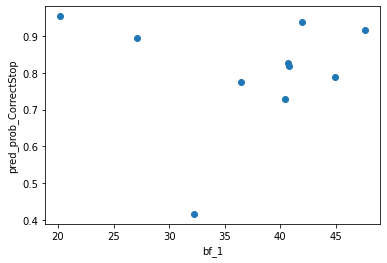

In [146]:
visualize_corr('bf_1','pred_prob_CorrectStop',full_dataset_cs)

In [128]:
full_dataset_cs['pred_prob_CorrectStop']

0      0.819215
1      0.819215
2      0.917560
3      0.917560
4      0.773995
         ...   
157         NaN
158         NaN
159         NaN
160         NaN
161         NaN
Name: pred_prob_CorrectStop, Length: 162, dtype: float64